In [1]:
library(tidyverse)
library(ggfortify)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.4
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()


# I. Contexte
Les données sont les enregistrements mensuels du nombre de morts, `death`, sur les accidents de la route au Royaume-Uni entre Janvier 1969 et Décembre 1983.  
La loi sur le port obligatoire de la ceinture de sécurité, `law`, a été introduite en Février 1983.

In [2]:
ukdeath <- read_delim("data.txt", delim = "  ", col_types = "if")
period <- seq(as.Date('1969-01-01'), as.Date('1984-12-31'), by = "month")

In [3]:
summary(ukdeath)

     death      law     
 Min.   :1057    0:169  
 1st Qu.:1462    1: 23  
 Median :1631           
 Mean   :1670           
 3rd Qu.:1851           
 Max.   :2654           

`geom_smooth()` using formula 'y ~ x'


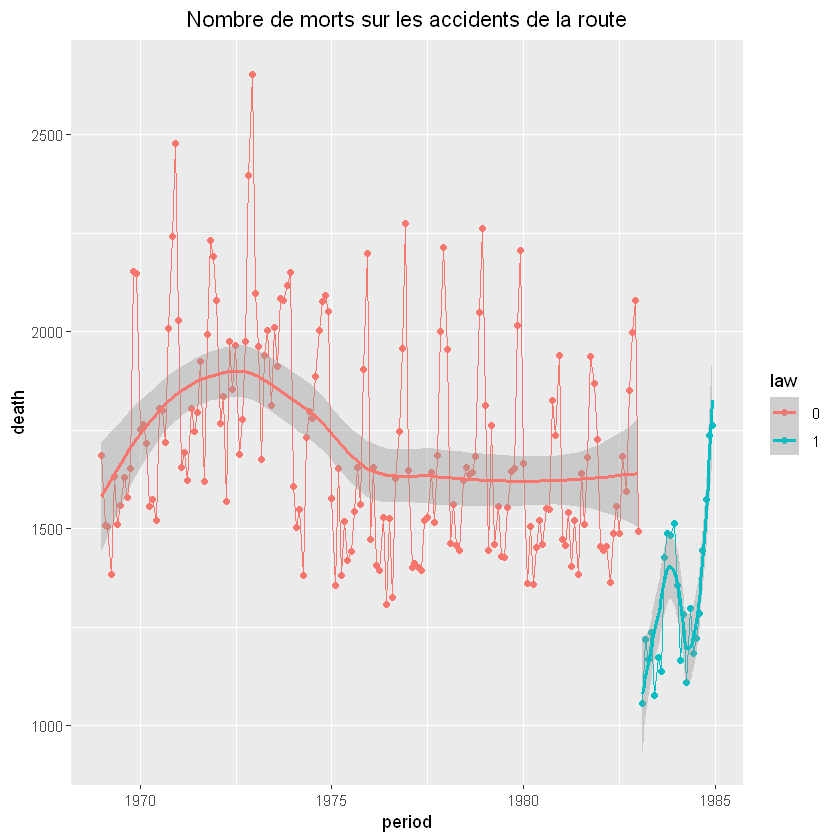

In [4]:
ggplot(ukdeath) +
aes(x = period, y = death, color = law) + 
geom_point() + geom_line() + stat_smooth(method = "loess") +
labs(title = "Nombre de morts sur les accidents de la route") +
theme(plot.title = element_text(hjust = 0.5))

# II. Modèle additif global
On ne prend pas en compte la variable `law`

In [5]:
ts_ukdeath <- ts(data = ukdeath$death, start = c(1969, 1), frequency = 12)

## 1. Analyse des sègments
En découpant la série en segments "homogènes" en moyenne et variance, on peut détecter 2 points de ruptures sans considérer celui de la limite, dont un à la promulgation de la loi.  
Ainsi on a trois segments:

- **1970 - 1975:** on sait pas, ça monte puis ça descend (mdr)
- **1975 - 1983:** Période stable
- **Après 1983:** Depuis la loi

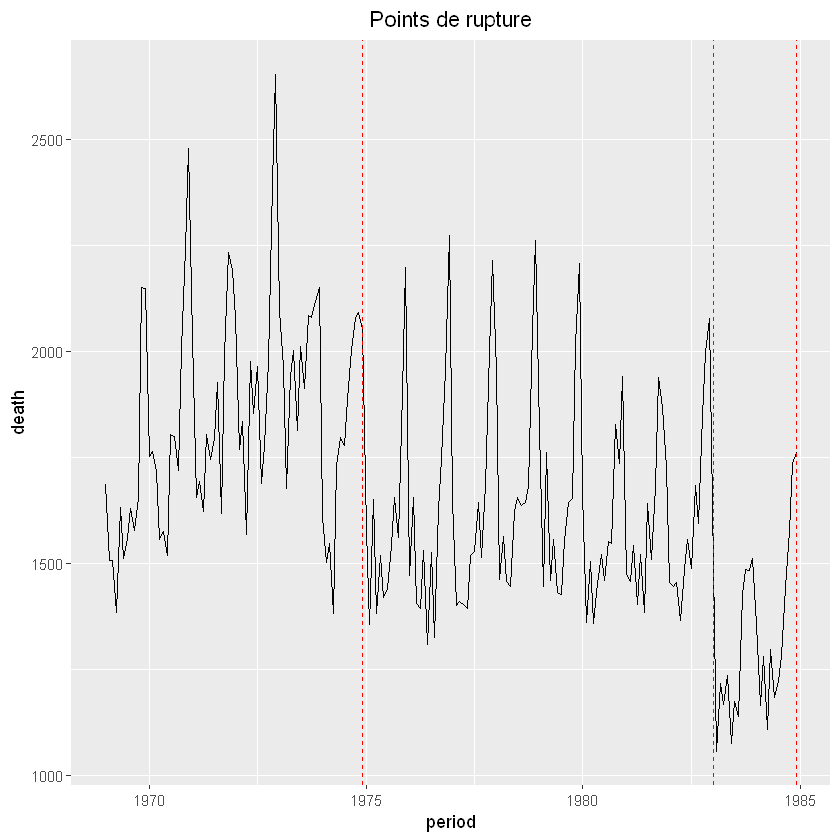

In [6]:
ts_ukdeath %>%
changepoint::cpt.meanvar(method = "PELT", minseglen = 11)  %>% 
autoplot() + labs(
    title = "Points de rupture",
    x = "period", y = "death"
) + theme(plot.title = element_text(hjust = 0.5))

\newpage

## 2. Analyse de chaque décomposition

In [7]:
stl_Add <- stl(ts_ukdeath, "periodic")

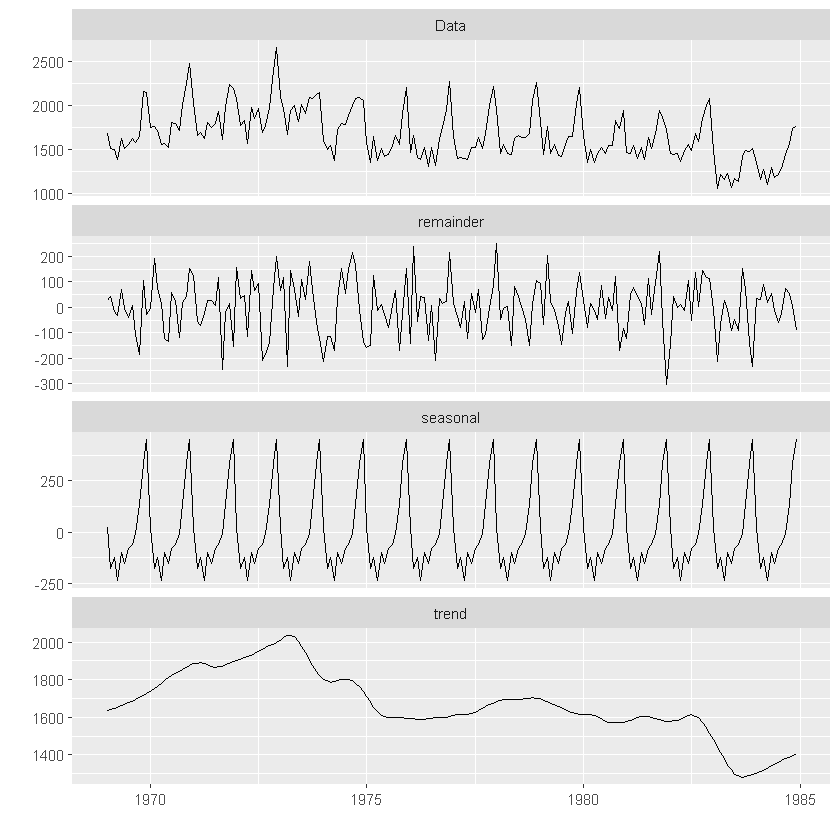

In [8]:
autoplot(stl_Add)

En visualisant la tendance globale (*trend*), on s'apperçoit qu'on obitient bien les 3 mêmes segments qu'avec le découpage par point de rupture ci-dessus.  
On remarque aussi qu'il existe une saisonalité (*seasonal*) avec une forte hausse des accidents pendant les périodes de fêtes de fin d'année (et du nouvel An aussi du coup).  
Le bruit (*remainder*) n'influe que peu sur les données (d'où la grande échelle à gauche).

## 3. Analyse du bruit
Procedons à l'analyse du bruit avec les fonctions d'autocorrélation et les tests de normalités.

In [9]:
noise <- stl_Add$time.series[,3]

### a - Fonctions d'autocorrélation
Visuellement, on ne détecte pas de motif sur les bruits. Ils seraient donc distribués aléatoirement.

L'**ACF** montre qu'il y a globalement peu d'autocorrélation. A des intervalles de 3 et 4 mois, on a des autocorrélations négatives plus fortes.  
Il s'agit de la forte différence de valeurs entre les débuts d'année en *février-mars-avril* et les derniers mois en *novembre-décembre-janvier*.

le **PACF** montre que les autocorrélations partielles sont globalement négatives, compte tenu des valeurs des intervalles intermédiaires.  
Il s'agit de la forte augmentation des valeurs à la fin par rapport à l'ensemble des données de l'année.


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method                 from     
  autoplot.Arima         ggfortify
  autoplot.acf           ggfortify
  autoplot.ar            ggfortify
  autoplot.bats          ggfortify
  autoplot.decomposed.ts ggfortify
  autoplot.ets           ggfortify
  autoplot.forecast      ggfortify
  autoplot.stl           ggfortify
  autoplot.ts            ggfortify
  fitted.ar              ggfortify
  fortify.ts             ggfortify
  residuals.ar           ggfortify


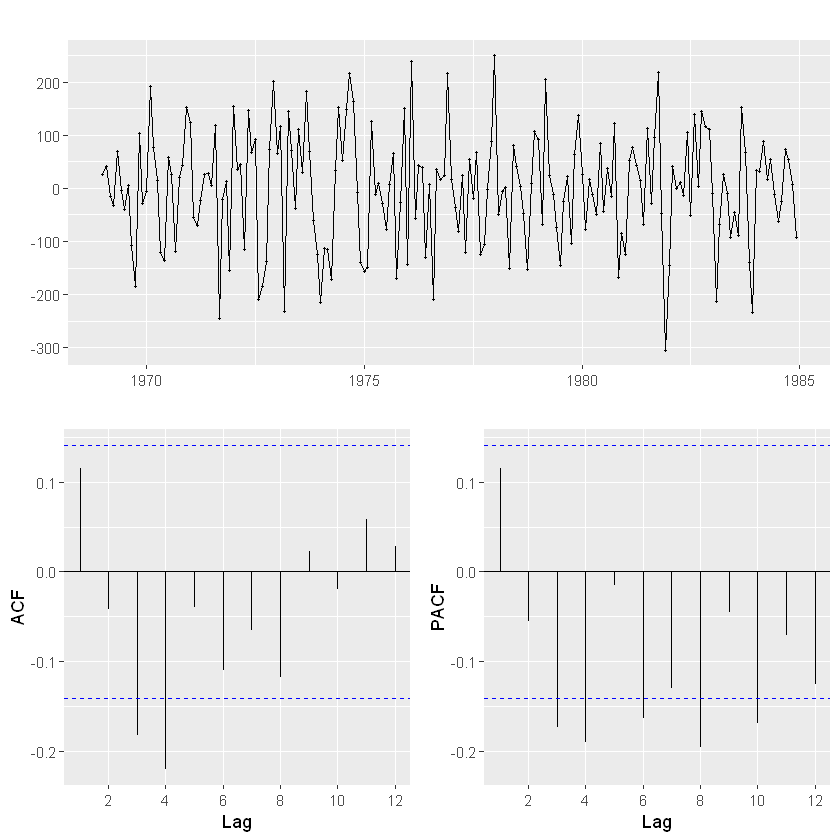

In [10]:
forecast::ggtsdisplay(noise,lag.max = 12)

### b - Normalité du bruit
Malgré la répartition du bruit preque normale, comme représentée ci-dessous, la p-value du test de Shapiro-Wilk est significative, 0.4 < 0.5.  
On rejette donc l'hypothèse de la normalité du bruit.

MU

In [19]:
t.test(noise)


	One Sample t-test

data:  noise
t = -0.014632, df = 191, p-value = 0.9883
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -15.25059  15.02600
sample estimates:
 mean of x 
-0.1122965 


    VAR

In [30]:
n <- length(noise)
s <- sd(noise)**2
a <- 0.05

In [29]:
s

[1] 11309.35

In [31]:
(n-1)*s/c(qchisq(a/2,n-1,lower.tail=FALSE), qchisq(a/2,n-1,lower.tail=TRUE))

[1]  9344.351 13970.212

In [11]:
shapiro.test(noise)


	Shapiro-Wilk normality test

data:  noise
W = 0.99224, p-value = 0.4


Warning message:
"Removed 1 rows containing non-finite values (stat_bin)."Warning message:
"Removed 1 rows containing non-finite values (stat_density)."Warning message:
"Removed 1 rows containing missing values (geom_bar)."

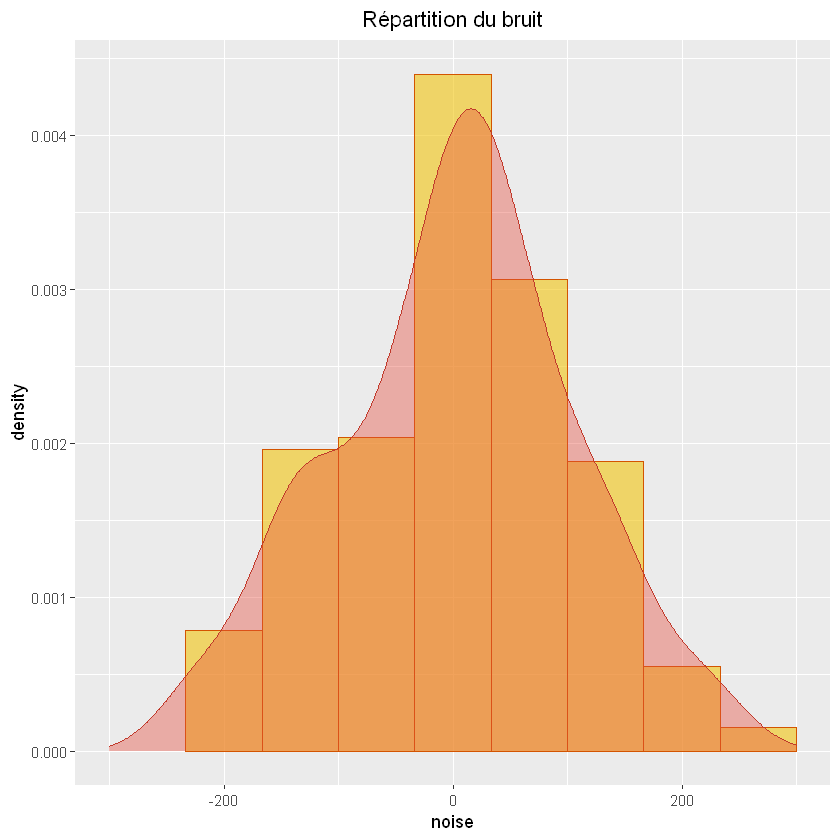

In [12]:
tibble(noise) %>% 
ggplot() + aes(x = noise) +
geom_histogram(aes(y=..density..), bins = 10, color = "#d35400", fill = "#f1c40f", alpha = 0.6) + 
geom_density(color = "#c0392b", fill = "#e74c3c", alpha = 0.4) +
labs(title = "Répartition du bruit") + xlim(c(-300, 300)) +
theme(plot.title = element_text(hjust = 0.5))

\newpage

# III. Modèle additif avec bruit

In [13]:
ts_bruit <- ts(data = noise, start = c(1969, 1), frequency = 12)

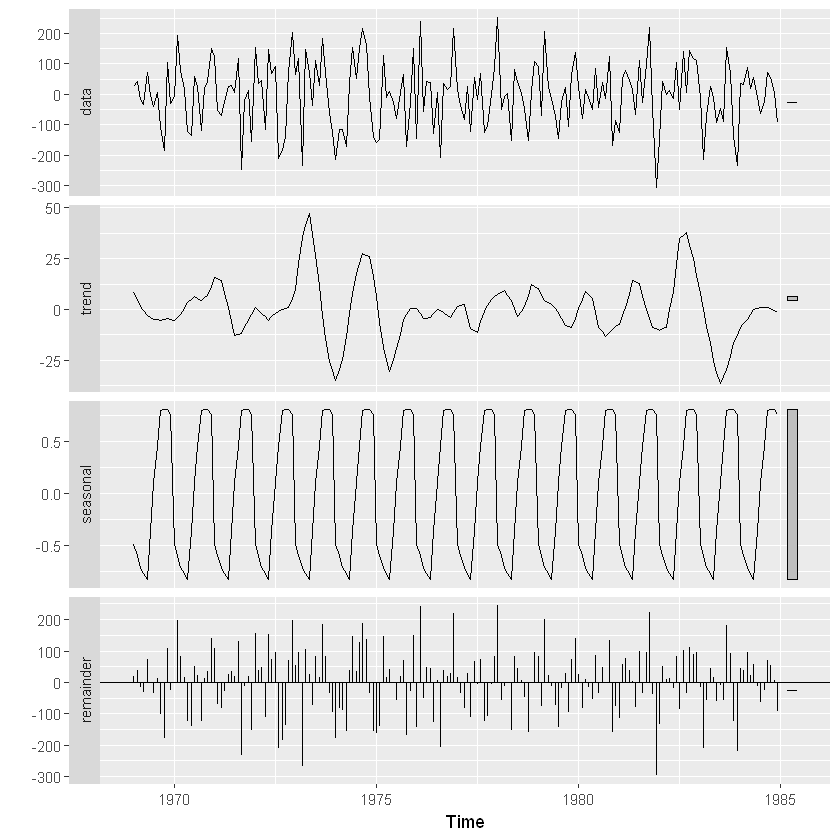

In [14]:
stl_bruit <- stl(ts_bruit, "periodic")
autoplot(stl_bruit)

On remarque que la saisonalité du bruit, même si elle existe, n'a quasiment pas d'effet sur celui-ci.  
Il possède en revanche une tendance globale.  
Toutefois, les données du bruit sont essentiellement expliquées par le bruit du bruit (*remainder*).